In [2]:
pip install numpy matplotlib opencv-python svgwrite cairosvg shapely

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.6 MB/s eta 0:00:00


<ipython-input-32-8e569766acfd>:76: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


Detected shapes:
Lines: []
Circles: [[122  82  82]
 [ 67  73  51]
 [145  37  59]]
Ellipses: [((115.81695556640625, 137.8218536376953), (53.634029388427734, 110.17833709716797), 90.44768524169922), ((63.64860153198242, 148.9072265625), (2.3790929317474365, 7.907063961029053), 127.871826171875), ((168.09727478027344, 149.23106384277344), (2.236829996109009, 11.59614086151123), 50.942962646484375), ((177.11221313476562, 141.388671875), (0.7400686740875244, 29.826627731323242), 44.878318786621094), ((43.577674865722656, 140.0), (2.5650787353515625, 12.25362491607666), 90.0), ((67.59617614746094, 136.61756896972656), (4.04110860824585, 45.05729293823242), 78.56278991699219), ((187.4591064453125, 130.8981475830078), (2.4675722122192383, 12.259385108947754), 47.14886474609375), ((307.7261657714844, 13.552436828613281), (109.53271484375, 658.0138549804688), 69.20187377929688), ((105.22976684570312, 127.57345581054688), (2.9894227981567383, 29.32721519470215), 73.5110855102539), ((124.928443908

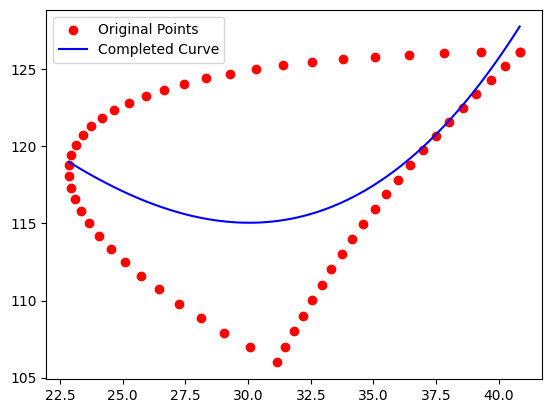

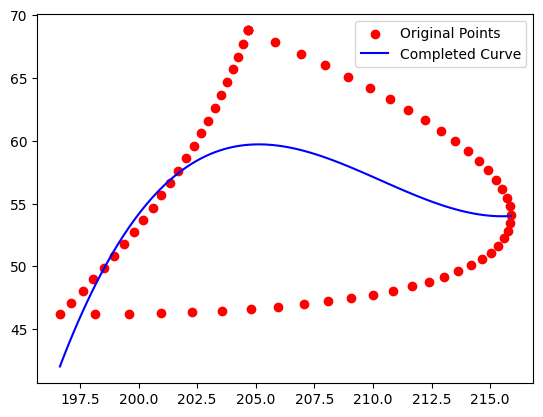

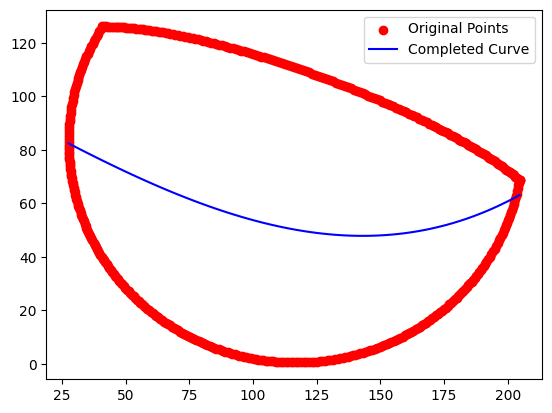

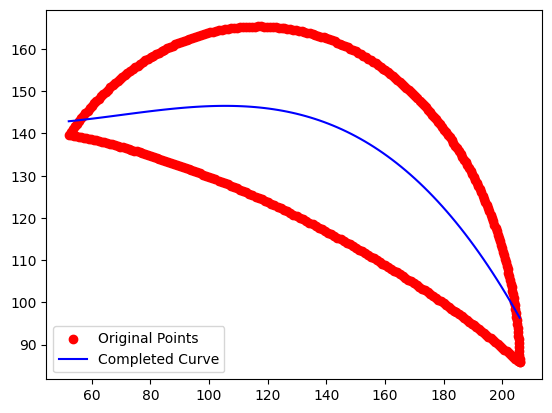

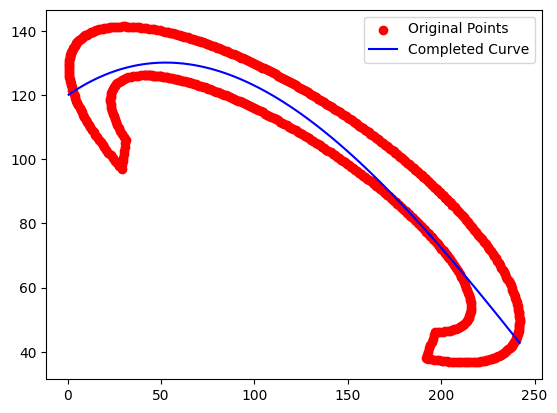

In [32]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import svgwrite

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def create_blank_image(img_shape):
    return np.ones(img_shape, dtype=np.uint8) * 255  # White background

def composite_shapes(paths_XYs, img_shape, shape_order):
    blank_image = create_blank_image(img_shape)
    for idx in shape_order:
        XYs = paths_XYs[idx]
        for XY in XYs:
            for x, y in XY:
                if 0 <= int(x) < img_shape[1] and 0 <= int(y) < img_shape[0]:
                    blank_image[int(y), int(x)] = 0  # Black shapes on white background
    return blank_image

def detect_shapes(image):
    shapes = {
        'lines': [],
        'circles': [],
        'ellipses': [],
        'rectangles': [],
        'rounded_rectangles': [],
        'stars': [],
        'polygons': []
    }

    # Ensure the image is in grayscale for edge detection and contour finding
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    edges = cv2.Canny(gray, 50, 150)

    # Line detection
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=50, maxLineGap=10)
    if lines is not None:
        shapes['lines'] = lines

    # Circle detection
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=50, param1=50, param2=30, minRadius=10, maxRadius=100)
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        shapes['circles'] = circles

    # Contour detection
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        # Fit ellipses to contours with at least 5 points
        if len(contour) >= 5:
            ellipse = cv2.fitEllipse(contour)
            shapes['ellipses'].append(ellipse)

        # Fit rectangles to contours with at least 4 points
        if len(contour) >= 4:
            rect = cv2.minAreaRect(contour)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            shapes['rectangles'].append(box)

        # Approximate polygons
        approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)
        if len(approx) >= 3:
            shapes['polygons'].append(approx)

        # Detect stars
        if len(contour) >= 5:
            moments = cv2.moments(contour)
            if moments['m00'] != 0:
                cx = moments['m10'] / moments['m00']
                cy = moments['m01'] / moments['m00']
                points = [point[0] for point in contour]
                points = sorted(points, key=lambda p: np.arctan2(p[1] - cy, p[0] - cx))
                # Check if the points are likely to form a star
                if len(points) >= 5:
                    shapes['stars'].append(points)

    return shapes



def detect_symmetry(path_XYs):
    def is_symmetric(points, axis):
        centroid = np.mean(points, axis=0)
        for point in points:
            reflected_point = point.copy()
            reflected_point[axis] = 2 * centroid[axis] - point[axis]
            if not np.any(np.all(np.isclose(points, reflected_point, atol=1e-6), axis=1)):
                return False
        return True

    centroid = np.mean(path_XYs, axis=0)

    if is_symmetric(path_XYs, axis=0):
        return True, 'x-axis'

    if is_symmetric(path_XYs, axis=1):
        return True, 'y-axis'

    return False, None

def detect_rotational_symmetry(path_XYs):
    def is_symmetric(points, angle):
        centroid = np.mean(points, axis=0)
        radians = np.radians(angle)
        rotation_matrix = np.array([
            [np.cos(radians), -np.sin(radians)],
            [np.sin(radians), np.cos(radians)]
        ])

        rotated_points = np.dot(points - centroid, rotation_matrix) + centroid

        for rotated_point in rotated_points:
            if not np.any(np.all(np.isclose(points, rotated_point, atol=1e-6), axis=1)):
                return False
        return True

    angles = [90, 180, 270]
    for angle in angles:
        if is_symmetric(path_XYs, angle):
            return True, f'{angle} degrees'

    return False, None

def complete_curve(path_XYs, degree=3, num_points=100):
    if len(path_XYs) < 2:
        raise ValueError("Not enough points to fit a curve.")

    X = path_XYs[:, 0]
    Y = path_XYs[:, 1]

    polynomial_features = PolynomialFeatures(degree=degree)
    X_poly = polynomial_features.fit_transform(X.reshape(-1, 1))
    model = LinearRegression()
    model.fit(X_poly, Y)

    X_new = np.linspace(X.min(), X.max(), num_points)
    X_new_poly = polynomial_features.transform(X_new.reshape(-1, 1))
    Y_new = model.predict(X_new_poly)

    plt.scatter(X, Y, color='red', label='Original Points')
    plt.plot(X_new, Y_new, color='blue', label='Completed Curve')
    plt.legend()
    plt.show()

def polylines2svg(paths_XYs, filename):
    dwg = svgwrite.Drawing(filename, profile='tiny')
    colours = ['black', 'red', 'green', 'blue', 'orange', 'purple', 'brown', 'cyan', 'magenta', 'yellow']

    for i, XYs in enumerate(paths_XYs):
        color = colours[i % len(colours)]
        for XY in XYs:
            points = [(x, y) for x, y in XY]
            # Fill the shape with color
            dwg.add(dwg.polygon(points, fill=color, stroke='none'))

    dwg.save()

def main():
    csv_path = "occlusion2.csv"
    paths_XYs = read_csv(csv_path)

    img_shape = (int(np.max([XY[:, 1].max() for XYs in paths_XYs for XY in XYs])) + 1,
                 int(np.max([XY[:, 0].max() for XYs in paths_XYs for XY in XYs])) + 1)

    # Define shape order for compositing
    shape_order = range(len(paths_XYs))  # Adjust this order if you want specific shapes on top

    composite_img = composite_shapes(paths_XYs, img_shape, shape_order)

    cv2.imwrite('composite_image.png', composite_img)

    shapes = detect_shapes(composite_img)

    print("Detected shapes:")
    for shape_type, detected in shapes.items():
        print(f"{shape_type.capitalize()}: {detected}")

    for i, path_XYs in enumerate(paths_XYs):
        reflection_symmetric, axis = detect_symmetry(np.vstack(path_XYs))
        rotational_symmetric, angle = detect_rotational_symmetry(np.vstack(path_XYs))

        print(f"Path {i} Reflection Symmetry: {reflection_symmetric}, Axis: {axis}")
        print(f"Path {i} Rotational Symmetry: {rotational_symmetric}, Angle: {angle}")

    for i, path_XYs in enumerate(paths_XYs):
        complete_curve(np.vstack(path_XYs))

    polylines2svg(paths_XYs, "output.svg")

if __name__ == "__main__":
    main()
